# Company Problem

In this notebook, our goal is to familiarize you with Logica while also enabling you to contrast Logica with SQL.

### Package Installation

First-time users need to install the following packages

In [1]:
!python3 -m pip install logica
!python3 -m pip install pandas
!pip install ipython-sql

After running the cell above, please restart the kernel to move on

### Package Import

You can disregard the messages ("Could not import ...") when executing the cell below

In [2]:
from logica import colab_logica
import pandas as pd
import sqlite3

Could not import google.cloud.bigquery.
Could not import google.cloud.auth.
Could not import google.colab.widgets.


In [3]:
colab_logica.SetPreamble(
    '@Engine("sqlite"); @AttachDatabase("mydata", "my_database.db");'
)

In [4]:
%load_ext sql

### Database Creation

Logica is typically run on a database. Since we only possess CSV files, we need first create a database.

In [5]:
Dep = pd.read_csv("datasets/Department.csv")
Dpd = pd.read_csv("datasets/Dependent.csv")
Dep_loc = pd.read_csv("datasets/Dept_Location.csv")
Emp = pd.read_csv("datasets/Employee.csv", dtype={"Super_ssn": "str"})
Proj = pd.read_csv("datasets/Project.csv")
Works_On = pd.read_csv("datasets/Works_On.csv", dtype={"Pno": "str"})

In [6]:
Dep.columns = Dep.columns.str.lower()
Dpd.columns = Dpd.columns.str.lower()
Dep_loc.columns = Dep_loc.columns.str.lower()
Emp.columns = Emp.columns.str.lower()
Proj.columns = Proj.columns.str.lower()
Works_On.columns = Works_On.columns.str.lower()

In [7]:
conn = sqlite3.connect("my_database.db")

Dep.to_sql("Department", conn, if_exists="replace", index=False)
Dpd.to_sql("Dependent", conn, if_exists="replace", index=False)
Dep_loc.to_sql("Dept_Location", conn, if_exists="replace", index=False)
Emp.to_sql("Employee", conn, if_exists="replace", index=False)
Proj.to_sql("Project", conn, if_exists="replace", index=False)
Works_On.to_sql("Works_On", conn, if_exists="replace", index=False)

conn.close()

### Queries

We've provided a range of queries, in SQL and Logica formats, sourced from the textbook "FUNDAMENTALS OF Database Systems". Consider these as your starting point. Enjoy!

#### Query 0: Retrieve the birth date and address of the employee(s) whose name is 'John B. Smith'.

$\mathrm{\sigma_{Fname='John' \land Minit='B' \land Lname='Smith'}(EMPLOYEE)}$

In [8]:
%%sql sqlite:///my_database.db
SELECT Bdate, Address
FROM EMPLOYEE
WHERE Fname='John' AND Minit='B' AND Lname='Smith'

Done.


bdate,address
1965-01-09,"731 Fondren,Houston,TX"


Query is stored at JohnSmith_sql variable.


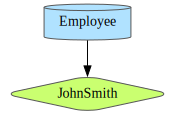

Running predicate: JohnSmith (1 ms)
The following table is stored at JohnSmith variable.


,bdate,address
0,1965-01-09,"731 Fondren,Houston,TX"


In [9]:
%%logica JohnSmith

JohnSmith(bdate:, address:) :- 
    Employee(bdate:, address:, fname:"John", minit:"B", lname:"Smith");

#### Query 1: Retrieve the name and address of all employees who work for the 'Research' department. 

$\mathrm{\Pi_{Fname, Lname, Address}(\sigma_{Dname='Research'}(DEPARTMENT\bowtie_{Dnumber=Dno}(EMPLOYEE))}$

In [10]:
%%sql sqlite:///my_database.db
SELECT Fname,Lname,Address
FROM EMPLOYEE,DEPARTMENT
WHERE Dname='Research' AND Dnumber=Dno;

Done.


fname,lname,address
Franklin,Wong,"638 Voss,Houston,TX"
John,Smith,"731 Fondren,Houston,TX"
Joyce,English,"5631 Rice,Houston,TX"
Ramesh,Narayan,"975 Fire Oak,Humble,TX"


Query is stored at ResearchDep_sql variable.


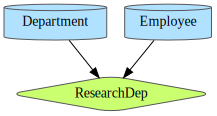

Running predicate: ResearchDep (1 ms)
The following table is stored at ResearchDep variable.


,fname,lname,address
0,Franklin,Wong,"638 Voss,Houston,TX"
1,John,Smith,"731 Fondren,Houston,TX"
2,Joyce,English,"5631 Rice,Houston,TX"
3,Ramesh,Narayan,"975 Fire Oak,Humble,TX"


In [11]:
%%logica ResearchDep

ResearchDep(fname:, lname:, address:):- 
    Employee(fname:, lname:, address:, dno:), 
    Department(dname:"Research", dnumber:dno);

#### Query 2: For every project located in 'Stafford', list the project number, the controlling department number, and the department manager's last name, address, and birth date. 

$\mathrm{\Pi_{Pnumber,Dnum,Lname,Address,Bdate}(((\sigma_{Plocation='Stafford'}(PROJECT))
\bowtie_{Dnum=Dnumber}(DEPARTMENT))\bowtie_{Mgr\_ssn=Ssn}(EMPLOYEE))}$

In [12]:
%%sql sqlite:///my_database.db
Select Pnumber,Dnum,Lname,Address,Bdate
From Project,Department,Employee
Where Dnum=Dnumber And Mgr_ssn=Ssn And Plocation='Stafford'

Done.


pnumber,dnum,lname,address,bdate
10,4,Wallace,"291 Berry,Bellaire,TX",1941-06-20
30,4,Wallace,"291 Berry,Bellaire,TX",1941-06-20


Query is stored at StaffordProj_sql variable.


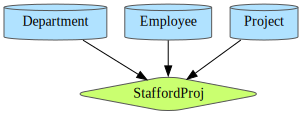

Running predicate: StaffordProj (1 ms)
The following table is stored at StaffordProj variable.


,pnumber,dnum,lname,address,bdate
0,10,4,Wallace,"291 Berry,Bellaire,TX",1941-06-20
1,30,4,Wallace,"291 Berry,Bellaire,TX",1941-06-20


In [13]:
%%logica StaffordProj

StaffordProj(pnumber:, dnum:, lname:, address:, bdate:):-
    Project(pnumber:, dnum:, plocation:"Stafford"), 
    Department(dnumber:dnum, mgr_ssn:),
    Employee(lname:, address:, ssn:mgr_ssn, bdate:);

#### Query 3: Who is the boss? The manager of the department that an employee works for!

$\mathrm{\Pi_{SSN, Lname, Address}(EMPLOYEE\bowtie_{Super\_Ssn=Ssn}(EMPLOYEE))}$

In [14]:
%%sql sqlite:///my_database.db

SELECT E.SSN as 'Employee', 
       M.SSN as 'Boss'
FROM   Employee E, 
       Employee M
WHERE E.Super_SSN = M.SSN
ORDER BY M.SSN;

Done.


Employee,Boss
123456789,333445555
666884444,333445555
453453453,333445555
333445555,888665555
987654321,888665555
999887777,987654321
987987987,987654321


Query is stored at EmpBoss_sql variable.


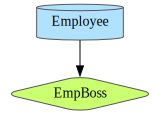

Running predicate: EmpBoss (1 ms)
The following table is stored at EmpBoss variable.


,employee,boss
0,123456789,333445555
1,333445555,888665555
2,999887777,987654321
3,987654321,888665555
4,666884444,333445555
5,453453453,333445555
6,987987987,987654321


In [15]:
%%logica EmpBoss

EmpBoss(employee:ssn,boss:super_ssn):- 
    Employee(ssn:, super_ssn:),Employee(ssn:super_ssn);

#### Query 4: Make a list of all project numbers for projects that involve an employee whose last name is ‘Smith’, either as a worker or as a manager of the department that controls the project.

$\mathrm{SMITHS(Essn) \leftarrow \pi_{Ssn}(\sigma_{Lname='Smith'}(EMPLOYEE))}$

$\mathrm{SMITH\_WORKER\_PROJS \leftarrow \pi_{Pno}(WORKS\_ON) \ast SMITHS}$

$\mathrm{MGRS \leftarrow \pi_{Lname,Dnumber}(EMPLOYEE \bowtie_{Ssn=Mgr\_ssn}DEPARTMENT)}$

$\mathrm{SMITH\_MANAGED\_DEPTS(Dnum) \leftarrow \pi_{Dnumber}(\sigma_{Lname='Smith'}(MGRS))}$

$\mathrm{SMITH\_MANAGED\_PROJS(Pno) \leftarrow \pi_{Pnumber}(SMITH\_MANAGED\_DEPTS * PROJECT)}$

$\mathrm{RESULT \leftarrow (SMITH\_WORKER\_PROJS \cup SMITH\_MANAGED\_PROJS)}$

In [16]:
%%sql sqlite:///my_database.db

SELECT DISTINCT P.Pnumber
FROM Project AS P
JOIN Department AS D ON P.Dnum = D.Dnumber
JOIN Employee AS E ON D.Mgr_ssn = E.ssn
WHERE E.Lname = 'Smith'

UNION

SELECT DISTINCT P.Pnumber
FROM Project AS P
JOIN Works_on AS W ON P.Pnumber = W.Pno
JOIN Employee AS E ON W.Essn = E.Ssn
WHERE E.Lname = 'Smith'

Done.


pnumber
1
2


Query is stored at SmithProj_sql variable.


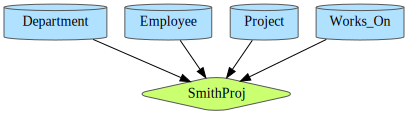

Running predicate: SmithProj (1 ms)
The following table is stored at SmithProj variable.


,pnumber
0,1
1,2


In [17]:
%%logica SmithProj

SmithProj(pnumber:pno):-
    Works_On(essn:, pno:),
    Employee(lname:"Smith",ssn:essn);
    
SmithProj(pnumber:):-
    Project(pnumber:, dnum:),
    Department(dnumber:dnum,mgr_ssn:),
    Employee(ssn:mgr_ssn, lname:"Smith");

#### Query 5: For each employee, retrieve the employee’s first and last name and the first and last name of his or her immediate supervisor.

$\mathrm{\Pi_{E\_fname, E\_lname, S\_fname, S\_lname}(EMPLOYEE\bowtie_{Super\_Ssn=Ssn}(EMPLOYEE))}$

In [18]:
%%sql sqlite:///my_database.db

SELECT E.Fname as E_fname, E.Lname as E_lname, S.Fname as S_fname, S.Lname as S_lname
FROM EMPLOYEE AS E, EMPLOYEE AS S
WHERE E.Super_ssn = S.Ssn;

Done.


E_fname,E_lname,S_fname,S_lname
John,Smith,Franklin,Wong
Franklin,Wong,James,Borg
Alicia,Zelaya,Jennifer,Wallace
Jennifer,Wallace,James,Borg
Ramesh,Narayan,Franklin,Wong
Joyce,English,Franklin,Wong
Ahmad,Jabbar,Jennifer,Wallace


Query is stored at EmpBossName_sql variable.


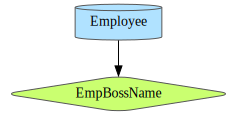

Running predicate: EmpBossName (1 ms)
The following table is stored at EmpBossName variable.


,e_fname,e_lname,s_fname,s_lname
0,John,Smith,Franklin,Wong
1,Franklin,Wong,James,Borg
2,Alicia,Zelaya,Jennifer,Wallace
3,Jennifer,Wallace,James,Borg
4,Ramesh,Narayan,Franklin,Wong
5,Joyce,English,Franklin,Wong
6,Ahmad,Jabbar,Jennifer,Wallace


In [19]:
%%logica EmpBossName

EmpBossName(e_fname:x, e_lname:y, s_fname:m,s_lname:l):- 
    Employee(fname:x, lname:y,super_ssn:),
    Employee(fname:m, lname:l,Ssn:super_ssn);

#### Query 6: Select all combinations of EMPLOYEE Ssn and DEPARTMENT Dname (Q10) in the database

$\mathrm{\sigma_{Ssn, Dname}EMPLOYEE \times DEPARTMENT}$

In [20]:
%%sql sqlite:///my_database.db
    
SELECT Ssn, Dname
FROM EMPLOYEE, DEPARTMENT

Done.


ssn,dname
123456789,Research
123456789,Administration
123456789,Headquarters
333445555,Research
333445555,Administration
333445555,Headquarters
999887777,Research
999887777,Administration
999887777,Headquarters
987654321,Research


Query is stored at SsnDname_sql variable.


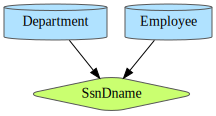

Running predicate: SsnDname (1 ms)
The following table is stored at SsnDname variable.


,ssn,dname
0,123456789,Research
1,123456789,Administration
2,123456789,Headquarters
3,333445555,Research
4,333445555,Administration
5,333445555,Headquarters
6,999887777,Research
7,999887777,Administration
8,999887777,Headquarters
9,987654321,Research


In [21]:
%%logica SsnDname

SsnDname(ssn:, dname:):-
    Employee(ssn:), Department(dname:);

#### Query 7: Show the resulting salaries if every employee working on the ‘ProductX’ project is given a 10% raise

$\mathrm{EMP\_PROJX \leftarrow \sigma_{Pname='ProjectX'}(WORKS\_ON \bowtie_{Pno=Pnumber} PROJECT)}$

$\mathrm{RESULT(Fname, Lname, Increased\_sal) \leftarrow \pi_{Fname, Lname, 1.1*Salary}(EMPLOYEE \bowtie_{Ssn=Essn} EMP\_PROJX)}$

In [22]:
%%sql sqlite:///my_database.db
    
SELECT E.Fname, E.Lname, 1.1 * E.Salary AS Increased_sal
FROM EMPLOYEE AS E, WORKS_ON AS W, PROJECT AS P
WHERE E.Ssn = W.Essn AND W.Pno = P.Pnumber AND
P.Pname = 'ProductX';

Done.


fname,lname,Increased_sal
John,Smith,33000.0
Joyce,English,27500.000000000004


Query is stored at IncreSal_sql variable.


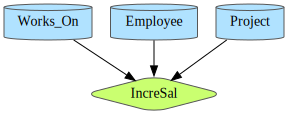

Running predicate: IncreSal (1 ms)
The following table is stored at IncreSal variable.


,fname,lname,increased_sal
0,John,Smith,33000.0
1,Joyce,English,27500.0


In [23]:
%%logica IncreSal

IncreSal(fname:, lname:, increased_sal:salary*1.1):-
    Employee(fname:, lname:,ssn:, salary:),
    Works_On(essn:ssn, pno:), 
    Project(pname:"ProductX",pnumber:pno);

## Logica Exercises

#### Exercise 1: Retrieve the name and address of all employees who work for the 'Administration' department. 

In [24]:
%%logica Ex1

# Insert your logica query here
Ex1(Fname:fn, Lname:ln, Address:ad):-

Parsing:
Q4(Fname:fn, Lname:ln, Address:ad):-<EMPTY>

[ Error ] Could not parse proposition.


#### Exercise 2: Retrieve the name of each employee who has a dependent with the same sex as the employee.

In [26]:
%%logica Ex2

# Insert your logica query here
Ex2(Fname:fn, Lname:ln, Dependent_name:dn):-

Parsing:
Ex2(Fname:fn, Lname:ln, Dependent_name:dn):-<EMPTY>

[ Error ] Could not parse proposition.
